In [37]:
# -*- coding:utf-8 -*-
import json
import requests
import csv
import re
from lxml import etree
from datetime import date,datetime
import pandas as pd
import math
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def save_interest_rate(data):

# 1. 创建文件对象
f = open('CB_interest_rate.test.csv', 'w', encoding='utf-8', newline='')
# 2. 基于文件对象构建 csv写入对象
csv_writer = csv.writer(f)
# 3. 构建列表头
csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])

count = 0
for item in data:
count +=1
if (count %10 == 0):
print("processing "+str(count)+" items")
try:
interest = get_interest_rate(item['id'])
interest = [item['id']]+interest
csv_writer.writerow(interest)
except Exception as e:
print("Oops!", e.__class__, "occurred.")
print("The error happed at "+item['id'])
# 5. 关闭文件
print("Finished processing "+str(count)+" items")
f.close()


In [95]:
def get_interest_rate(id):
years = 6
detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
detials_response = requests.get(detials_url)
html = detials_response.content.decode("utf-8")
html = etree.HTML(html)
interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
if(not interest_text[0].find('%')):
print(" not in interest test %s %s"%(id,interest_text))
pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
else:
pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
interest = pattern.findall(interest_text[0])
if(len(interest) <= 1):
print("%s fixed interest rate %s"%(id, interest_text[0]))
interest = interest*years
elif(len(interest)<5):
print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
print("You may need to check manually")
elif(len(interest)>6):
print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
print("You may need to check manually")
interest = [rate.strip("%") for rate in interest]
return interest

In [48]:
def get_dat():
# Fill in your details here to be posted to the login form.
payload = {
'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
}
headers = {
"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
#"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
"Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
}
loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
r = requests.post(loginUrl,data=payload)

newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
#最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
response = requests.get(newUrl,cookies=r.cookies)
data = response.content.decode("utf-8")
dat = json.loads(data)

# 所有数据
lst_data = []
count = 0
for one in dat['rows']:
# 每一条数据
lst_dat = dict()
# 转债id
id = one["id"]
dat_cell = one["cell"]
# 是否赎回
is_force_redeem = dat_cell['redeem_flag']
is_list = dat_cell['price_tips']

if is_list != "待上市":

count += 1
if (count %100 == 0):
print("processing "+str(count)+" items")

# 转债名称
name = dat_cell['bond_nm']
# 现价
price = dat_cell['price']
# stock id
stock_id = dat_cell['stock_id']
stock_id = stock_id.replace("sh", "ss")
stock_id = stock_id[2:]+"."+stock_id[0:2]
# stock name
stock_nm = dat_cell['stock_nm']
# 溢价率
premium_rt = dat_cell['premium_rt']
# 评级
rating_cd = dat_cell['rating_cd']


# next put date
next_put_dt = dat_cell['next_put_dt']
# put price
put_price   = dat_cell['put_price']
# 回售触发价
put_convert_price = dat_cell['put_convert_price']


# maturity date
maturity_dt = dat_cell['maturity_dt']
# redeem price
redeem_price = dat_cell['redeem_price']

# 强赎触发价
redeem_dt = dat_cell['redeem_dt']
force_redeem_price = dat_cell['force_redeem_price']
# 剩余时间
last_time = dat_cell['year_left']
pb = dat_cell['pb']


#lst_dat.append(id)
lst_dat['id'] = id
lst_dat['name'] = name
lst_dat['stock_id'] = stock_id
lst_dat['stock_name'] = stock_nm
lst_dat['price'] = float(price)
lst_dat['convert_value'] = float(dat_cell['convert_value'])
lst_dat['premium_rt'] = premium_rt
lst_dat['rating_cd'] = rating_cd
lst_dat['pb']  = pb
lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']



lst_dat['next_put_dt'] = next_put_dt
lst_dat['put_price'] = put_price
lst_dat['put_convert_price'] = put_convert_price

lst_dat['maturity_dt'] = maturity_dt
lst_dat['redeem_price'] = redeem_price
lst_dat['last_time'] = last_time
lst_dat['force_redeem'] = is_force_redeem

lst_dat['redeem_dt']  = redeem_dt
lst_dat['force_redeem_price'] = force_redeem_price

  
lst_data.append(lst_dat)

else:
continue
print("Finished processing "+str(count)+" items")

return lst_data

In [6]:
interest = html.xpath('.//td[@id="cpn_desc"]/text()')
interest

['第一年为 0.40%、第二年为 0.60%、第三年为 1.20%、第四年为 2.20%、 第五年为 3.50%、第六年为 4.00%']

In [46]:
cb1 = get_interest_rate('113049')

In [47]:
cb1

['0.2%', '0.4%', '0.6%', '0.8%', '1.5%', '2.0%']

In [27]:
cb2 = get_interest_rate('120003')

['第1年1.0%,第2年1.0%,第3年1.0%,第4年1.0%,第5年1.0%']


In [25]:
cb3 = get_interest_rate('132018')

['第1年0.5%,第2年0.5%,第3年0.5%,第4年0.5%,第5年0.5%']


In [18]:
cb4 = get_interest_rate('128125')

['第一年 0.4%、第二年 0.6%、第三年 1.0%、第四年 1.5%、第五年 2.0%、第 六年 3.0%。到期赎回价为 113 元(含最后一期利息)']


In [32]:
re.findall(r'(?<!\d|\.)\d+(?:\.\d+)%', cb4[0])

['0.4%', '0.6%', '1.0%', '1.5%', '2.0%', '3.0%']

In [26]:
re.findall(r'(?<!\d|\.)\d+(?:\.\d+)%', cb3[0])

['0.5%', '0.5%', '0.5%', '0.5%', '0.5%']

In [28]:
re.findall(r'(?<!\d|\.)\d+(?:\.\d+)%', cb2[0])

['1.0%', '1.0%', '1.0%', '1.0%', '1.0%']

In [30]:
re.findall(r'(?<!\d|\.)\d+(?:\.\d+)%', cb1[0])

['0.2%', '0.4%', '0.6%', '0.8%', '1.5%', '2.0%']

In [96]:
#data = get_dat()
save_interest_rate(data)

120004 only 1 interest rate 券票面利率为1.0%
processing 10 items
132014 only 1 interest rate 每年固定0.9%
processing 20 items
processing 30 items
processing 40 items
processing 50 items
processing 60 items
processing 70 items
processing 80 items
processing 90 items
processing 100 items
processing 110 items
processing 120 items
processing 130 items
processing 140 items
processing 150 items
processing 160 items
127035 odd number of interest rate 第一年 0.6%、第二年 0.8%、第三年 1.5%、第四年 3.0%、第五年 3.8
processing 170 items
processing 180 items
processing 190 items
processing 200 items
processing 210 items
processing 220 items
processing 230 items
processing 240 items
processing 250 items
processing 260 items
processing 270 items
processing 280 items
processing 290 items
processing 300 items
132022 odd number of interest rate 0.10%,0.10%,0.10%,
processing 310 items
processing 320 items
processing 330 items
processing 340 items
processing 350 items
132009 only 1 interest rate 每年固定1%
132015 only 1 interest rate 每年

In [66]:
get_interest_rate('113569')

113569 2-4 第一年为 0.4%、第二年为 0.8%、第三年为 1%、第四年为 1.5%、第五年 为 2%、第六年为 3%


['0.4%', '0.8%', '1.5%']

In [97]:
detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+'127035'
detials_response = requests.get(detials_url)
html = detials_response.content.decode("utf-8")
html = etree.HTML(html)
interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')

In [100]:
pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
interest = pattern.findall(interest_text[0])
interest

['0.6%', '0.8%', '1.5%', '3.0%']

In [94]:
interest2 = [rate.strip("?\s%") for rate in interest]
interest2

['0.50', '0.70 ', '1.00 ', '1.50', '2.50', '3.00']

In [99]:
pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
interest2 = pattern.findall(interest_text[0])
interest2

['0.6', '0.8', '1.5', '3.0', '3.8']

In [56]:
# Fill in your details here to be posted to the login form.
payload = {
'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
}
headers = {
"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
#"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
"Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
}
loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
r = requests.post(loginUrl,data=payload)

newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
#最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
response = requests.get(newUrl,cookies=r.cookies)
data = response.content.decode("utf-8")
dat = json.loads(data)

[10.00036268  5.00015215  1.99990806  5.00007758]


<ipython-input-9-d800e2dedd63>:29: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


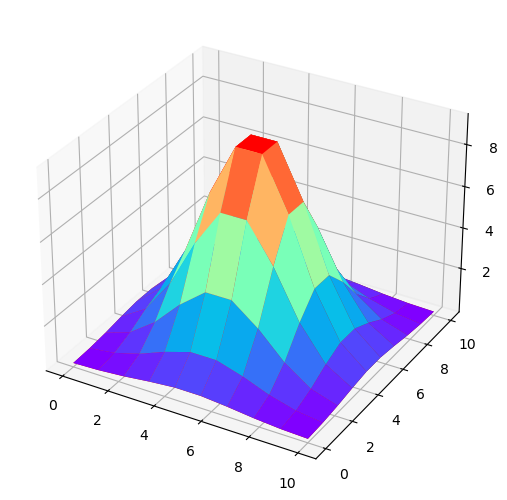

In [9]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
def func1(x, a, b, c, d):
    r =  a * np.exp(-((x[0] - b) ** 2 + (x[1] - d) ** 2) / (2 * c ** 2))
    return r.ravel()

# 生成原始数据
x1 = np.linspace(0, 10, 10).reshape(1, -1)
x2 = np.linspace(0, 10, 10).reshape(1, -1)
x = np.append(x1, x2, axis=0)
X, Y = np.meshgrid(x1, x2)
XX = np.expand_dims(X, 0)
YY = np.expand_dims(Y, 0)
xx = np.append(XX, YY, axis=0)
y = func1(xx, 10, 5, 2, 5)
# 对原始数据增加噪声
yn = y + 0.002 * np.random.normal(size=xx.shape[1] * xx.shape[2])

# 使用curve_fit函数拟合噪声数据
popt, pcov = curve_fit(func1, xx, yn)

# popt返回最拟合给定的函数模型func的参数值
print(popt)

fig = plt.figure('拟合图')
ax = Axes3D(fig)
X, Y = np.meshgrid(x1, x2)
XX = np.expand_dims(X, 0)
YY = np.expand_dims(Y, 0)
xx = np.append(XX, YY, axis=0)
R = func1(xx, *popt)
# R, _ = np.meshgrid(R, x1)
# y = func1(xx, 10, 5, 2, 5)
# # 对原始数据增加噪声
# yn = y = 0.002 * np.random.normal(size=xx.shape[1] * xx.shape[2])
R = R.reshape(10, 10)
yn = yn.reshape(10, 10)
ax.plot_surface(X, Y, R, rstride=1, cstride=1, cmap='rainbow')
ax.plot_surface(X, Y, yn, rstride=1, cstride=1, color='red')

plt.show()

In [12]:
x[0]

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [13]:
x[1]

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [14]:
x.shape

(2, 10)

In [15]:
yn.shape

(10, 10)

In [17]:
y

array([0.01930454, 0.06634765, 0.16747502, 0.31047958, 0.42274118,
       0.42274118, 0.31047958, 0.16747502, 0.06634765, 0.01930454,
       0.06634765, 0.22802977, 0.57559374, 1.06708515, 1.45291626,
       1.45291626, 1.06708515, 0.57559374, 0.22802977, 0.06634765,
       0.16747502, 0.57559374, 1.45291626, 2.69354104, 3.66745761,
       3.66745761, 2.69354104, 1.45291626, 0.57559374, 0.16747502,
       0.31047958, 1.06708515, 2.69354104, 4.99351789, 6.79904815,
       6.79904815, 4.99351789, 2.69354104, 1.06708515, 0.31047958,
       0.42274118, 1.45291626, 3.66745761, 6.79904815, 9.25741266,
       9.25741266, 6.79904815, 3.66745761, 1.45291626, 0.42274118,
       0.42274118, 1.45291626, 3.66745761, 6.79904815, 9.25741266,
       9.25741266, 6.79904815, 3.66745761, 1.45291626, 0.42274118,
       0.31047958, 1.06708515, 2.69354104, 4.99351789, 6.79904815,
       6.79904815, 4.99351789, 2.69354104, 1.06708515, 0.31047958,
       0.16747502, 0.57559374, 1.45291626, 2.69354104, 3.66745

In [27]:
x = np.linspace(0,6)
y1 = x**0.5
y2 = x**0.25
y3 = x**0.1

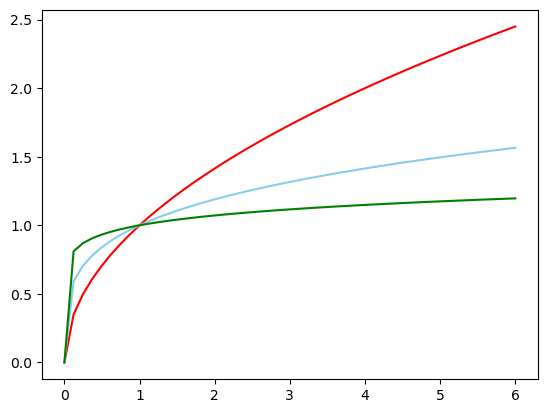

In [28]:
plt.plot(x,y1,color='red')
plt.plot(x,y2,color='skyblue')
plt.plot(x,y3,color='green')
plt.show()

In [34]:
11.9*6**0.25

18.62450650287212

In [33]:
5.2*6**0.5

12.737346662472525

In [101]:
import tushare as ts

In [104]:
pro = ts.pro_api('c914778bc260d3911212f2a37620ffa89ca4706e44fd557673b509a2')

In [169]:
XSG_URL = '%sdatainterface.%s/EM_DataCenter/%s?type=FD&sty=BST&st=3&sr=true&fd=%s&stat=%s'
XSG_COLS = ['id','code', 'name', 'date', 'count', 'ratio']
ZF = '%s%s/tsdata/%s.csv'
FORMAT = lambda x: '%.2f' % x
P_TYPE = {'http': 'http://', 'ftp': 'ftp://'}
DOMAINS = {'sina': 'sina.com.cn', 'sinahq': 'sinajs.cn',
           'ifeng': 'ifeng.com', 'sf': 'finance.sina.com.cn',
            'vsf': 'vip.stock.finance.sina.com.cn',
            'idx': 'www.csindex.com.cn', '163': 'money.163.com',
            'em': 'eastmoney.com', 'sseq': 'query.sse.com.cn',
            'sse': 'www.sse.com.cn', 'szse': 'www.szse.cn',
            'oss': 'file.tushare.org', 'idxip':'115.29.204.48',
            'shibor': 'www.shibor.org', 'mbox':'www.cbooo.cn',
            'tt': 'gtimg.cn', 'gw': 'gw.com.cn',
            'v500': 'value500.com', 'sstar': 'stock.stockstar.co    m',
            'dfcf': 'nufm.dfcfw.com'}

PAGES = {'fd': 'index.phtml', 'dl': 'downxls.php', 'jv': 'json_v2.php',
         'cpt': 'newFLJK.php', 'ids': 'newSinaHy.php', 'lnews':'rollnews_ch_out_interface.php',
         'ntinfo':'vCB_BulletinGather.php', 'hs300b':'000300cons.xls',
         'hs300w':'000300closeweight.xls','sz50b':'000016cons.xls',         
         'dp':'all_fpya.php', '163dp':'fpyg.html',
         'emxsg':'JS.aspx', '163fh':'jjcgph.php',
         'newstock':'vRPD_NewStockIssue.php', 'zz500b':'000905cons.xls',
         'zz500wt':'000905closeweight.xls',
         't_ticks':'vMS_tradedetail.php', 'dw': 'downLoad.html',
         'qmd':'queryMargin.do', 'szsefc':'ShowReport.szse',
         'ssecq':'commonQuery.do', 'sinadd':'cn_bill_download.php', 'ids_sw':'SwHy.php',
         'idx': 'index.php', 'index': 'index.html'}

In [162]:
year = datetime.today().year
month = datetime.today().month
year = 2022
month = 2

In [163]:
request = requests.get(XSG_URL%(P_TYPE['http'], DOMAINS['em'],PAGES['emxsg'], year, month))

In [242]:
def get_restricted_shares(stock_id):
    url = 'http://datacenter-web.eastmoney.com/api/data/v1/get?callback=jQuery112305678710086023377_1630414549986&sortColumns=FREE_DATE&sortTypes=-1&pageSize=500&pageNumber=1&reportName=RPT_LIFT_STAGE&filter=(SECURITY_CODE="'+stock_id+'")&columns=SECURITY_CODE,SECURITY_NAME_ABBR,FREE_DATE,CURRENT_FREE_SHARES,ABLE_FREE_SHARES,LIFT_MARKET_CAP,FREE_RATIO,NEW,B20_ADJCHRATE,A20_ADJCHRATE,FREE_SHARES_TYPE,TOTAL_RATIO,NON_FREE_SHARES,BATCH_HOLDER_NUM&source=WEB&client=WEB'
    my_request = requests.get(url)
    my_lines = my_request.content.decode("utf-8")
    p1 = re.compile(r'[(](.*)[)]',re.S)
    my_json = re.findall(p1,my_lines)
    dat = json.loads(my_json[0])
    return pd.DataFrame.from_dict(dat['result']['data'])

In [244]:
get_restricted_shares('000538')

,SECURITY_CODE,SECURITY_NAME_ABBR,FREE_DATE,CURRENT_FREE_SHARES,ABLE_FREE_SHARES,LIFT_MARKET_CAP,FREE_RATIO,NEW,B20_ADJCHRATE,A20_ADJCHRATE,FREE_SHARES_TYPE,TOTAL_RATIO,NON_FREE_SHARES,BATCH_HOLDER_NUM
0,000538,云南白药,2023-06-27 00:00:00,7136.8938,7136.8938,6.329711e+05,0.118180,88.69,NaN,NaN,定向增发机构配售股份,0.055795,680.6164,1
1,000538,云南白药,2022-12-28 00:00:00,59706.1258,59706.1258,5.295336e+06,0.988675,88.69,NaN,NaN,定向增发机构配售股份,0.466769,7817.5102,2
2,000538,云南白药,2012-01-10 00:00:00,6500.0000,6500.0000,3.391700e+05,0.093627,52.18,-14.242424,2.866117,定向增发机构配售股份,0.093624,2.1100,1


In [208]:
request = requests.get(XSG_URL%(P_TYPE['http'], DOMAINS['em'],PAGES['emxsg'], year, month))

In [217]:
json.loads(my_lines)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [246]:
stock_id = '000538'
r = requests.get('https://vip.stock.finance.sina.com.cn/corp/go.php/vISSUE_AddStock/stockid/'+stock_id+'.phtml')

In [236]:

temp_df = pd.read_html(r.text)[12]
if temp_df.at[0, 0] == '对不起，暂时没有相关增发记录':
    print(f"股票 {stock} 无增发记录")
big_df = pd.DataFrame()
for i in range(int(len(temp_df.at[0, 1]) / 10)):
    temp_df = pd.read_html(r.text)[13+i].iloc[:, 1]
    big_df[temp_df.name.split(" ")[1].split("：")[1][:10]] = temp_df 
    big_df = big_df.T
    #big_df.columns = ["发行方式", "发行价格", "实际公司募集资金总额", "发行费用总额", "实际发行数量"]

In [237]:
big_df

,2007-08-22
0,网上优先配售、网上定价发行
1,31.53元
2,"1,000,000.00万元"
3,"6,339.83万元"
4,31715.8261万股
2006-12-25,NaN


In [247]:
pd.read_html(r.text)[14].iloc[:,1]

0          网下定价发行
1          27.87元
2    139,350.00万元
3      2,951.60万元
4          5000万股
Name: 增发 公告日期：2008-12-30.1, dtype: object

In [234]:
r.text

'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\r\n<html xmlns="http://www.w3.org/1999/xhtml">\r\n<head>\r\n<meta http-equiv="Content-Type" content="text/html; charset=gb2312" />\r\n<meta http-equiv="Content-Security-Policy" content="upgrade-insecure-requests">\r\n<title>京东方A(000725)增发_新浪财经_新浪网</title>\r\n<meta name="Keywords" content="京东方A增发,000725增发,新浪财经京东方A(000725)增发" />\r\n<meta name="Description" content="新浪财经京东方A(000725)行情中心,为您提供京东方A(000725)增发信息数据查询." />\r\n<link media="all" rel="stylesheet" href="/corp/view/css/newstyle.css" />\r\n<link media="all" rel="stylesheet" href="/corp/view/css/tables.css" />\r\n<link media="all" rel="stylesheet" href="/corp/view/css/style4.css" />\r\n\r\n<style type="text/css">\r\nbody,ul,ol,li,p,h1,h2,h3,h4,h5,h6,form,fieldset,table,td,img,div{margin:0;padding:0;border:0;}\r\nbody,ul,ol,li,p,form,fieldset,table,td{font-family:"宋体";}\r\nbody{background:#fff;color:#000;}\r\ntd,p,l

In [164]:
XSG_URL%(P_TYPE['http'], DOMAINS['em'],PAGES['emxsg'], year, month)

'http://datainterface.eastmoney.com/EM_DataCenter/JS.aspx?type=FD&sty=BST&st=3&sr=true&fd=2022&stat=2'

In [179]:
lines = request.content.decode("utf-8")
#html = etree.HTML(html)
#interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbe in position 336: invalid start byte

In [170]:
da = lines[3:len(lines)-3]
list =  []
for row in da.split('","'):
    list.append([data for data in row.split(',')])
df = pd.DataFrame(list)
df = df[[0,1, 3, 4, 5, 6]]
for col in [5, 6]:
    df[col] = df[col].astype(float)
df[5] = df[5]/10000
df[6] = df[6]*100
df[5] = df[5].map(FORMAT)
df[6] = df[6].map(FORMAT)
df.columns = XSG_COLS

In [171]:
df

,id,code,name,date,count,ratio
0,80303276,002938,鹏鼎控股,2022-02-28,3701.61,1.59
1,80470162,002949,华阳国际,2022-02-28,7971.30,40.66
2,80143235,300078,思创医惠,2022-02-28,304.08,0.35
3,80172692,300212,易华录,2022-02-28,263.49,0.40
4,80184822,300274,阳光电源,2022-02-28,277.50,0.19
...,...,...,...,...,...,...
186,80692117,002947,恒铭达,2022-02-01,9467.11,57.50
187,80195005,300327,中颖电子,2022-02-01,41.90,0.14
188,80201106,300421,力星股份,2022-02-01,258.50,1.04
189,81019009,688607,康众医疗,2022-02-01,4621.21,52.44


In [175]:
df.loc[df['id'].str.startswith('1')]

,id,code,name,date,count,ratio
7,10000257,600315,上海家化,2022-02-28,201.63,0.30
14,10001918,688396,华润微,2022-02-27,781.25,0.59
25,10001028,000711,京蓝科技,2022-02-25,9009.15,8.80
30,10001452,002050,三花智控,2022-02-24,459.81,0.13
46,10000540,600733,北汽蓝谷,2022-02-23,118816.54,27.71
64,10001040,000725,京东方A,2022-02-20,293224.42,7.63
67,10001360,600985,淮北矿业,2022-02-20,152233.19,61.36
70,10001077,000778,新兴铸管,2022-02-19,1175.77,0.29
73,10000825,600876,洛阳玻璃,2022-02-19,8390.48,13.00
74,10000921,000584,哈工智能,2022-02-18,1068.38,1.40


In [115]:
df = pro.share_float(ts_code='300532.SZ')

In [116]:
df

,ts_code,ann_date,float_date,float_share,float_ratio,holder_name,share_type
0,300532.SZ,20190820,20190822,127862388.0,46.4895,邵健伟,首发原始股
1,300532.SZ,20190820,20190822,17125344.0,6.2266,邵健锋,首发原始股
2,300532.SZ,20190820,20190822,8562672.0,3.1133,深圳市华锐丰投资合伙企业(有限合伙),首发原始股
3,300532.SZ,20180818,20190819,127862388.0,46.1175,邵健伟,首发原始股
4,300532.SZ,20180818,20190819,17125344.0,6.1768,邵健锋,首发原始股
5,300532.SZ,20180818,20190819,8562672.0,3.0884,深圳市华锐丰投资合伙企业(有限合伙),首发原始股
6,300532.SZ,20160809,20160818,838.0,0.0010,宝盈祥泰混合型证券投资基金,首发股


In [117]:
df = pro.share_float(ts_code='000157.SZ')

In [121]:
df

,ts_code,ann_date,float_date,float_share,float_ratio,holder_name,share_type
0,000157.SZ,20210208,20210810,37069816.0,0.4274,湖南迪策鸿泰投资合伙企业(有限合伙),定增股份
1,000157.SZ,20210208,20210810,39331366.0,0.4534,中信建投证券股份有限公司,定增股份
2,000157.SZ,20210208,20210810,54277286.0,0.6257,财通基金管理有限公司,定增股份
3,000157.SZ,20210208,20210810,39331366.0,0.4534,摩根士丹利国际股份有限公司,定增股份
4,000157.SZ,20210208,20210810,74434611.0,0.8581,乌鲁木齐凤凰基石股权投资管理有限合伙企业-凤凰基石同力私募股权投资基金,定增股份
5,000157.SZ,20210208,20210810,148869223.0,1.7163,马鞍山煊远基石股权投资合伙企业(有限合伙),定增股份
6,000157.SZ,20210208,20210810,73746312.0,0.8502,"JPMorganChaseBank,NationalAssociation",定增股份
7,000157.SZ,20210208,20210810,44149459.0,0.5090,UBSAG,定增股份
8,000157.SZ,20210208,20210810,37069816.0,0.4283,湖南迪策鸿泰投资合伙企业(有限合伙),定增股份
9,000157.SZ,20210208,20210810,39331366.0,0.4544,中信建投证券股份有限公司,定增股份


In [120]:
df['float_ratio'].sum()

27.954599999999996

In [132]:
pro.share_float(ts_code='600562.SH')

,ts_code,ann_date,float_date,float_share,float_ratio,holder_name,share_type
0,600562.SH,20200620,20230619,538212052.0,44.7217,中国电子科技集团公司第十四研究所,定增股份
1,600562.SH,20200620,20230619,19429117.0,1.6144,中电国睿集团有限公司,定增股份
2,600562.SH,20200620,20230619,9968561.0,0.8283,上海巽潜投资管理合伙企业(有限合伙),定增股份
3,600562.SH,20200620,20230619,8743102.0,0.7265,北京华夏智讯技术有限公司,定增股份
4,600562.SH,20200620,20230619,2977712.0,0.2474,张少华,定增股份
5,600562.SH,20200620,20230619,1788842.0,0.1486,胡华波,定增股份
6,600562.SH,20200620,20230619,9968581.0,0.8027,上海巽潜投资管理合伙企业(有限合伙),定增股份
7,600562.SH,20200728,20210125,6525911.0,0.5255,安信证券资产管理有限公司,定增股份
8,600562.SH,20200728,20210125,5118362.0,0.4122,山东惠瀚产业发展有限公司,定增股份
9,600562.SH,20200728,20210125,3326935.0,0.2679,泰康资产管理有限责任公司(泰康人寿保险有限责任公司-分红-个人分红-019L-FH002沪),定增股份
